In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true";
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00";
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async";
print(os.environ.get("TF_GPU_ALLOCATOR"))
print(os.environ.get("XLA_PYTHON_CLIENT_PREALLOCATE"))
import jax
import jax.numpy as jnp;
from types import SimpleNamespace;
from pathlib import Path
import numpy as np
from functools import partial
from gnlse_medium import *
from gnlse_source import *
from gnlse_solver import *
from gnlse_events import *
from gnlse_visualizations import *
import matplotlib.pyplot as plt
import gc; 
gc.collect();

jax.config.update("jax_enable_x64", True);
print(jax.devices());
jr64 = 'float64';
jc128 = 'complex128';

dev = jax.devices()[0]
stats = dev.memory_stats() 
def gb(x): return x / 1e9

print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

None
true
[CudaDevice(id=0)]
used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB


/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")


jax.clear_caches()

stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB
used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB


In [3]:
#########################################################################################
'''Spatio-temporal params: '''

Nx = Ny = 512;
Lx = Ly = 300e-6;
Lz = 5e-2;
Lt = 10e-12; # Length of time in seconds
Nt = 1; # Number of time steps
dx = Lx/Nx;
dy = Ly/Ny;


X, Y = make_space(Lx, Nx, Ly, Ny);

In [4]:
#########################################################################################
''' Refractive index profile (GRIN in this example): '''

n_core = 1.453; #n_clad = 1.451; ''' core and cladding index '''
NA = 0.06; # numerical aperture
n_clad = np.sqrt(n_core**2 - NA**2); # cladding index from NA
print("n_clad: ", n_clad)
r_core = 40e-6; ''' core radius '''
alpha = 2.0; ''' Index profile exponent (alpha = 2 for parabolic GRIN) '''

nxy = make_supergauss_index(X, Y, n_core = n_core, n_clad = n_clad, r_core = r_core, m =20);
#nxy = make_polynomial_n(X, Y, n_core = n_core, n_clad = n_clad, r_core = r_core, alpha = alpha);
n_xyomega = jnp.tile(nxy[:,:,None], (1,1 , Nt));

n_clad:  1.4517606552045692


In [5]:
###########################################################################################
''' Solve for modes; comment outR,R if folder is already populated:
(Note: Modes specific to particular Lx, Nx, Ly, Ny -> X, Y grid!):
(Note:  n_ref is usually the core index, n_core): '''

lambda0 = 1064e-9; ''' 1030 nm '''
n_modes = 40;
folder = Path("modes_GRIN_40umcore_60NA_1453ncore_300x300um_Nx512_Ny512"); 

''' Comment out when folder populated '''
#solve_modes(n_xy=nxy, n_ref = n_core, x = X[:, 0], y = Y[0, :], lambda0 = lambda0,
#            n_modes = n_modes, folder = folder, maxiter = 5000, tol = 1e-9);

' Comment out when folder populated '

In [6]:
############################################################################################
''' Build a field from the discovered modes: '''

weights_init = {1: 1.0}#, 9: 1.0 + 1.6j/2} #, 100: 1.0 + 1j/2, 101: 1.0 + 1j/2, 102: 1.0 + 1j/2,};
field_unscaled, indices, coeffs = make_source_from_files(folder="modes_GRIN_40umcore_60NA_1453ncore_300x300um_Nx512_Ny512", heading="mode", file_format = "npz", weights = weights_init);
E_xy, weights = norm_scale_field_weights(field_unscaled, indices, coeffs, power = 1.0, dx = dx, dy = dy);

[2863.56421266+0.j]
(512, 512, 1)


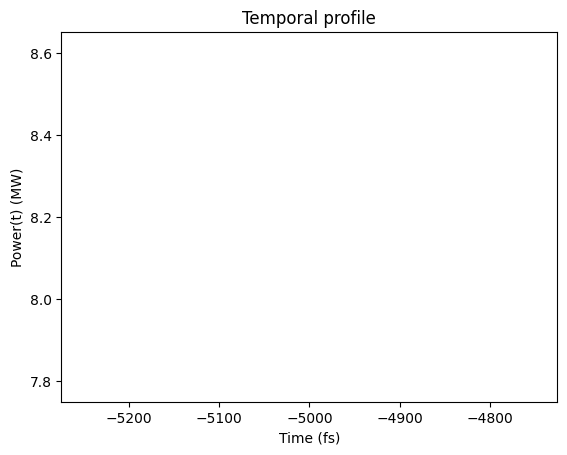

In [7]:
############################################################################################
power = 8.20000e6; ''' 8.2 MW '''

''' Define temporal profile '''
phis = 0.0;
t0 = 0.0;
fwhm = 120e-15; ''' 120 fs '''
phase = 0.0;
omega0 = 2 * jnp.pi / lambda0; ''' Carrier frequency in rad/s '''
T = jnp.linspace(-Lt/2, Lt/2, Nt); # time grid`

#E_t = cw_temp_profile(jnp.array(lambda0, dtype = jnp.float64), phis, Lt=Lt, Nt=Nt);
#E_t = gaussian_pulse_profile(t0, fwhm, Lt, Nt, carrier_omega=omega0, phase=phase)
lambdas = jnp.array([1030e-9])
phis    = jnp.array([0.0])
E_t_cw  = cw_temp_profile_freq(lambdas, phis, Lt, Nt)
# Gaussian: 150 fs FWHM, centered at t0=0, with a carrier shift
#E_t_gauss = gaussian_pulse_profile_freq(t0=0.0, fwhm=150e-15, Lt=Lt, Nt=Nt, carrier_omega=0.0, phase=0.0)

E_t = jnp.sqrt(power) * E_t_cw;
print(E_t)

plt.figure();
plt.plot(T * 1e15, np.abs(E_t)**2 / 1e6);
plt.xlabel("Time (fs)"); plt.ylabel("Power(t) (MW)");
plt.title("Temporal profile");

field = combine_spatial_temporal(E_xy, E_t) ;
print(jnp.shape(field));

power:  8.200000000000003  MW


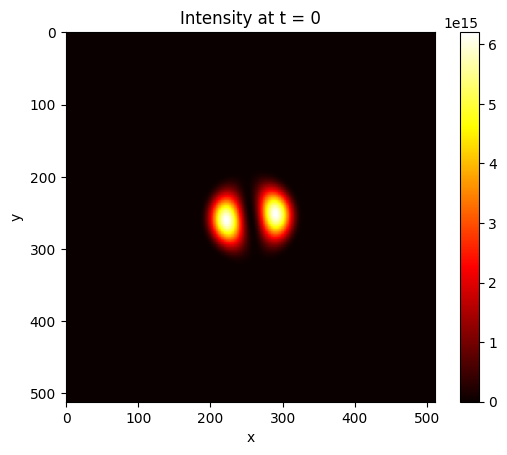

In [8]:
t_index =  int(Nt / 2); # Time index to visualize
I_xy = jnp.real(field[:, :, t_index])**2 + jnp.imag(field[:, :, t_index])**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy / 1e6, " MW");


plt.figure()
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity at t = {t_index}");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

In [9]:
#############################################################################################
''' Define remaining params: '''
c = 2.998e8;
beta0 = n_core * 2 * jnp.pi / lambda0;
print("beta0: ", beta0);
n_g = 1.468; # group index
beta1 = n_g / c;
beta2 = 22e-27; # 1.0; # Dispersion coefficient in s^2/m
n2 = 2.22e-20; ''' 2.22e-20 m^2/W '''
omega = None;

pml_thickness = 40;
pml_Wmax = 1e12;
''' args '''



beta0:  8580327.303883402


' args '

In [ ]:
# override from previous cells:
Lz = 10e-2; # Length of propagation in z
n_slots = 500;
save_at = jnp.linspace(0, Lz, n_slots, endpoint=True); # save at these positions in z
#print(save_at)
n2 = 2.76e-20

##########
args = {"Lx" : Lx, "Ly": Ly, "Lz": Lz, "Lt": Lt,   # spatiotemporal dimensions
        "Nx": Nx, "Ny": Ny, "Nt": Nt,              # spatial and temporal grid
        "n_xyomega": n_xyomega, "n2": n2, "nref": n_clad, # potential params
        "beta0": beta0, "beta1" : beta1,       # propagation params
        "beta2": beta2, "lambda0": lambda0,    # propagation params
        "save_at": save_at,                   # array of z positions to save at
        "deltaZ": 1e-6,                       # linear step size
        "deltaZ_NL":1e-6,                      # nonlinear step size
        "saturation_intensity": 5e-5,          #
        "gain_coeff": 0.0,
        "gain_fwhm": 0.0,
        "t1": 12.2e-15, "t2": 32e-15,       
        "pml_thickness": pml_thickness, "pml_Wmax":  pml_Wmax,
        "fr": 0.0, "sw": 0,                   # raman fraction (0.0 for no raman) and 
        "precision": "fp64",
        "ckpt_strategy": 'none',
        "ckpt_tree_depth": 1,
       };

stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

used     : 0.023076864 GB
peak     : 0.031459072 GB
total    : 0.0 GB
largest free block: 0.0 GB


In [11]:
results = GNLSE3D_propagate(args, field); 

/home/josalferr/.local/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1268: UserWarning: Some donated buffers were not usable: complex128[512,512,1].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


used     : 1.0716544 GB
peak     : 2.14959744 GB
total    : 0.0 GB
largest free block: 0.0 GB
(512, 512, 1, 500)
power:  8.102864  MW


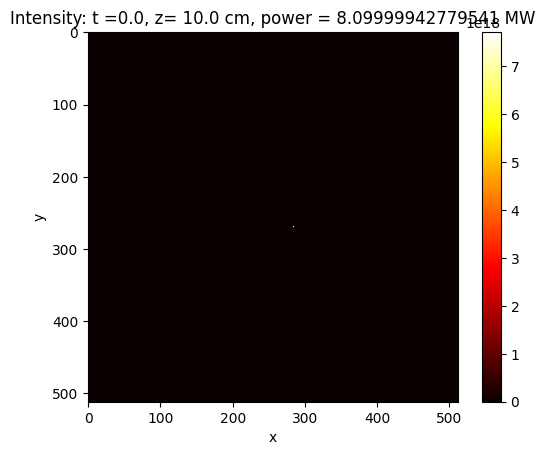

In [12]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

slot = -1; # Last save slot
time = 0; # Time slot to visualize
print(results["field"].shape);

res_field = results["field"][:, :, time, slot];

I_xy = jnp.real(res_field)**2 + jnp.imag(res_field)**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy * 1e-6 , " MW");

plt.figure();
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity: t ={time * Lt/Nt}, z= {round(save_at[slot], 3)*100} cm, power = {round(P_xy * 1e-6, 2)} MW");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

(<Figure size 800x400 with 2 Axes>,
 <Axes: title={'center': 'z vs X — aperture ±1px, ∫ dt | z∈[0,0.1] | x∈[-5.08e-05,5.08e-05]'}, xlabel='z (m)', ylabel='x (m)'>,
 array([-5.07827789e-05, -5.01956947e-05, -4.96086106e-05, -4.90215264e-05,
        -4.84344423e-05, -4.78473581e-05, -4.72602740e-05, -4.66731898e-05,
        -4.60861057e-05, -4.54990215e-05, -4.49119374e-05, -4.43248532e-05,
        -4.37377691e-05, -4.31506849e-05, -4.25636008e-05, -4.19765166e-05,
        -4.13894325e-05, -4.08023483e-05, -4.02152642e-05, -3.96281800e-05,
        -3.90410959e-05, -3.84540117e-05, -3.78669276e-05, -3.72798434e-05,
        -3.66927593e-05, -3.61056751e-05, -3.55185910e-05, -3.49315068e-05,
        -3.43444227e-05, -3.37573386e-05, -3.31702544e-05, -3.25831703e-05,
        -3.19960861e-05, -3.14090020e-05, -3.08219178e-05, -3.02348337e-05,
        -2.96477495e-05, -2.90606654e-05, -2.84735812e-05, -2.78864971e-05,
        -2.72994129e-05, -2.67123288e-05, -2.61252446e-05, -2.55381605e-05,


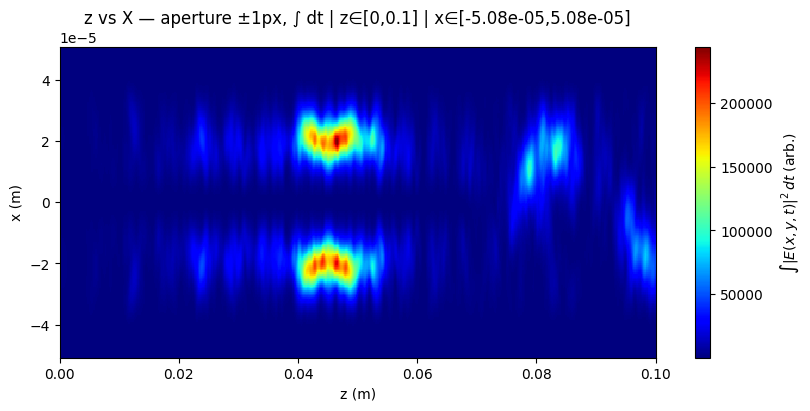

In [13]:
make_transverse_vs_z_vs_I_plot(results, args, axis="x", z_window=(0.00, 0.1),
                               axis_window=(-51e-6, 51e-6),
                               mode="time_integrated",
                               reduce="aperture", aperture_px=1,
                               log10=False, normalize=False)

In [14]:
# Create an animation of the field intensity over time
from importlib import reload
import gnlse_visualizations
reload(gnlse_visualizations);
from gnlse_visualizations import make_xy_z_animation
gif_path = make_xy_z_animation(results["field"], t_index=-1, quantity='intensity', norm='per_frame',
                               fps=50, filename='80um_GRIN_LP11_5cm.gif')
print("Saved animation to:", gif_path)


Saved animation to: 80um_GRIN_LP11_5cm.gif


In [15]:
info = compute_self_focusing_pixel_intensity(10e6, n2, dx, dy, safety=0.05, include_delta_n_cap=True);
I_thresh = info['I_thresh']
print("threshold intensity:", I_thresh);

def collapse_event(field_xyt, z, payload):
    return jnp.max(jnp.abs(field_xyt)**2) > I_thresh;

threshold intensity: 5.2536231884057965e+17


In [ ]:
results_prime = GNLSE3D_propagate(
    args, field,
    event_fn=collapse_event,
    event_payload={'I_thresh': I_thresh},  # W/m^2
    stop_on_event=True,
    event_check_every=1
)
print(results_prime['stopped_early'], results_prime['z_event'])

/home/josalferr/.local/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1268: UserWarning: Some donated buffers were not usable: complex128[512,512,1].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


In [ ]:
print(results_prime['z_event'] / Lz * 100, "% of Lz");
stop_step = np.int32(np.floor(results_prime['z_event'] / Lz * n_slots))
print("Stopped at step:", stop_step);

73.173 % of Lz
Stopped at step: 365


used     : 3.169856256 GB
peak     : 4.245703168 GB
total    : 0.0 GB
largest free block: 0.0 GB
(512, 512, 1, 500)
power:  8.199724  MW


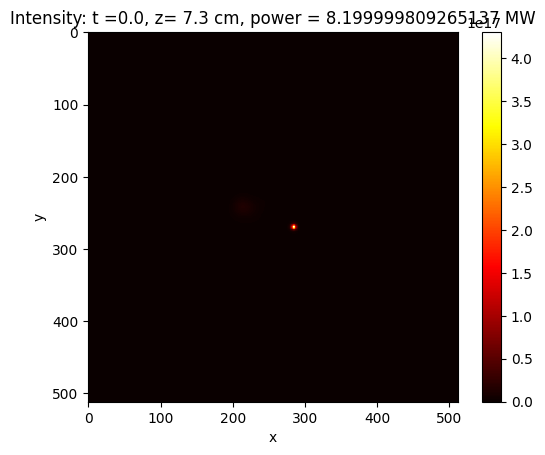

In [ ]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

slot = stop_step; # Last save slot
time = 0; # Time slot to visualize
print(results_prime["field"].shape);

res_field_p = results_prime["field"][:, :, time, slot];

I_xy = jnp.real(res_field_p)**2 + jnp.imag(res_field_p)**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy * 1e-6 , " MW");

plt.figure();
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity: t ={time * Lt/Nt}, z= {round(save_at[slot], 3)*100} cm, power = {round(P_xy * 1e-6, 2)} MW");
plt.xlabel("x");    plt.ylabel("y");
plt.show();